In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate as rt

In [2]:
def time_decorator(func):
    from time import time
    def wrapper(*arge, **kwarge):
        tic = time()
        result = func(*arge, **kwarge)
        toc = time()
        print(f"{func.__name__} took {toc-tic:.4} sec")
        return result
    return wrapper

In [3]:
def displayImageActualSize(img):
    import matplotlib as mpl
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape
    figsize = H/float(dpi), W/float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    plt.show()

In [4]:
def bilinearInterpolation(img, row, col):
    up_idx = int(row)
    down_idx = up_idx + 1
    left_idx = int(col)
    right_idx = left_idx + 1

    up_wight = abs(row - down_idx)
    down_weight = 1 - up_wight
    right_wight = abs(col - left_idx)
    left_wight = 1 - right_wight
    if (up_idx >= 0 and down_idx < img.shape[0]) and (left_idx >= 0 and right_idx < img.shape[1]):
        img_pix = {
            'upleft' : img[up_idx, left_idx],
            'upright' : img[up_idx, right_idx],
            'downleft' : img[down_idx, left_idx],
            'downright' : img[down_idx, right_idx]
        }
        
        up_point = (left_wight * img_pix['upleft']) + (right_wight * img_pix['upright'])
        down_point =(left_wight * img_pix['downleft']) + (right_wight * img_pix['downright'])
        point = (down_weight * down_point) + (up_wight * up_point)
        
        return np.uint16(point)
        
    else:
        return 0

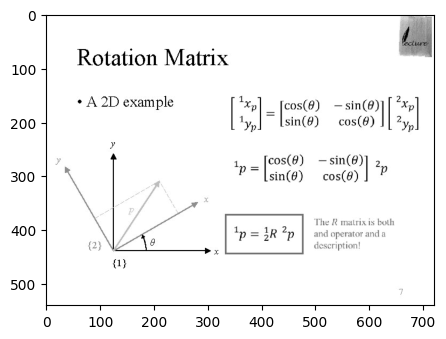

In [5]:
img = cv.imread('rotate2.jpeg', cv.IMREAD_GRAYSCALE)
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')

# we should handle negative number 

In [6]:
d = 45
r = np.deg2rad(d)
s = np.array([[np.cos(r), -np.sin(r)],
              [np.sin(r), np.cos(r)]])
s

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [8]:
img = cv.imread('einstein.jpg', cv.IMREAD_GRAYSCALE)

In [9]:
d = 45
r = np.deg2rad(d)
s = np.array([[np.cos(r), -np.sin(r)],[np.sin(r), np.cos(r)]])

row, col = img.shape[0], img.shape[1]
#creat an array of image corner cordinate
cords = np.array([[0, 0],
                  [0, col-1],
                  [row-1, 0],
                  [row-1, col-1]])
#calculate new cordinate after rotation
cords_prim = np.dot(s, cords.T)

minR, minC = np.min(cords_prim, axis=1).astype(np.int64)
maxR, maxC = (np.ceil(np.max(cords_prim, axis=1))).astype(np.int64)

#calculate new image height and width
H = maxR - minR + 1
W = maxC - minC + 1

img2 = np.zeros((H, W), dtype=np.uint16)

In [8]:
s_inv = np.linalg.inv(s)
for i in range (minR, maxR):
    for j in range(minC, maxC):
        p_prim = np.array([i, j])
        p = np.dot(s_inv, p_prim)
        new_i, new_j = p
            
        img2[i - minR, j - minC] = bilinearInterpolation(img, new_i, new_j)

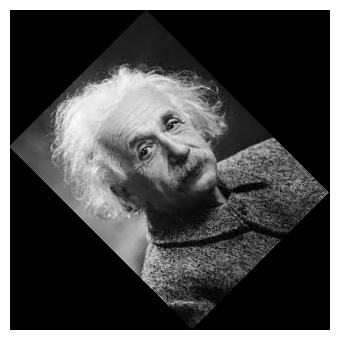

In [9]:
displayImageActualSize(img2)

In [5]:
def boundry(img, s):
    row, col = img.shape[0], img.shape[1]
    cords = np.array([[0, 0], [0, col-1], [row-1, 0], [row-1, col-1]])
    cords_prim = np.dot(s, cords.T)
    minR, minC = np.min(cords_prim, axis=1).astype(np.int64)
    maxR, maxC = (np.ceil(np.max(cords_prim, axis=1))).astype(np.int64)
    H = maxR - minR + 1
    W = maxC - minC + 1
    
    return minR, minC, maxR, maxC, H, W

In [6]:
def transform(img, s):
    minR, minC, maxR, maxC, H, W = boundry(img, s)
    img2 = np.zeros((H, W), dtype=np.uint16)
    s_inv = np.linalg.inv(s)
    for i in range (minR, maxR):
        for j in range(minC, maxC):
            p_prim = np.array([i, j])
            p = np.dot(s_inv, p_prim)
            new_i, new_j = p

            img2[i - minR, j - minC] = bilinearInterpolation(img, new_i, new_j)
    
    return img2

In [17]:
def boundry(img, s):
    row, col = img.shape[0], img.shape[1]
    cords = np.array([[0, 0], [0, col-1], [row-1, 0], [row-1, col-1]])
    cords_prim = np.dot(s, cords.T)
    minR, minC = np.min(cords_prim, axis=1).astype(np.int64)
    maxR, maxC = (np.ceil(np.max(cords_prim, axis=1))).astype(np.int64)
    H = maxR - minR + 1
    W = maxC - minC + 1
    
    return minR, minC, maxR, maxC, H, W

def img_transform_gray_vectorize(img_gray, scaler):
    minR, minC, maxR, maxC, row, col = boundry(img_gray, s)

    s_inv = np.linalg.inv(scaler)
    row_step, col_step = np.dot(s, [1, 1])
    row_weight, col_weight = np.dot(s_inv, [1, 1])

    img2 = np.zeros((row, col), dtype=np.uint16)
    img2[::row_step, ::col_step]= img_gray

    catalist_col = np.repeat(img_gray, 2, axis=1)
    catalist_col_ = np.hstack((catalist_col[:, 1:],
                               catalist_col[:, -1].reshape(-1, 1)))
    av_col = np.average(catalist_col_.reshape(-1, 2),
                        axis=1, weights=(col_step-1, 1)).reshape(-1, col)

    for j in range(1, col_step):
        img2[::row_step, j::col_step] = av_col + (2 * (j-1) * col_weight) / (col_step-1)

    catalist_row = np.repeat(img2[::row_step,:].T, 2, axis=1)
    catalist_row_ = np.hstack((catalist_row[:, 1:],
                               catalist_row[:, -1].reshape(-1, 1)))
    av_row = np.average(catalist_row_.reshape(-1, 2),
                        axis=1, weights=(row_step-1, 1)).reshape(-1, row).T

    for i in range(1, row_step):
        img2[i::row_step, :] = av_row + (2 * (i-1) * row_weight) / (row_step-1)

    return img2

In [47]:
x = np.array([[1, 2, 3], [3, 5, 2], [7, 9, 1]])
# x = np.array([[0, 0, 0 ,0, 0], [0, 1, 2, 3, 0], [0, 3, 5, 2, 0], [0, 7, 9, 1, 0], [0, 0, 0 ,0, 0]])
d = -45
r = np.deg2rad(d)
s = np.array([[np.cos(r), -np.sin(r)],[np.sin(r), np.cos(r)]])
# s = np.array([[2, 0], [0, 5]])
# img2 = img_transform_gray_vectorize(x, s)
# np.linalg.inv(s)
# np.where(x==1)[0], np.where(x==1)[1]
print(x)
rt(x, angle=45, reshape=True)

[[1 2 3]
 [3 5 2]
 [7 9 1]]


array([[0, 0, 0, 0],
       [0, 2, 3, 0],
       [0, 3, 8, 0],
       [0, 0, 0, 0]])

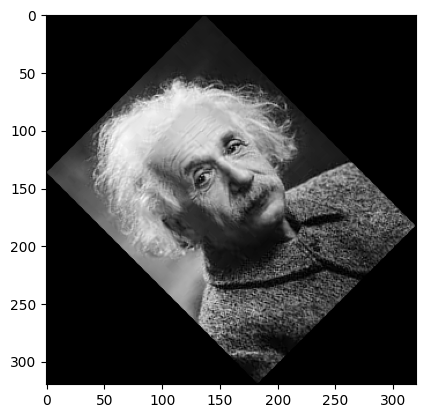

In [46]:
img = cv.imread('einstein.jpg', cv.IMREAD_GRAYSCALE)
r = rt(img, angle=45)
plt.imshow(r, cmap='gray')

In [132]:
s = np.array([[2, 0, 0], [0, 5, 0], [0, 0, 1]])
new = np.repeat(s, 4, axis=0)
x = np.array(vec_func(s, s))
x

array([[[2, 0, 0],
        [0, 5, 0],
        [0, 0, 1]],

       [[2, 0, 0],
        [0, 5, 0],
        [0, 0, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

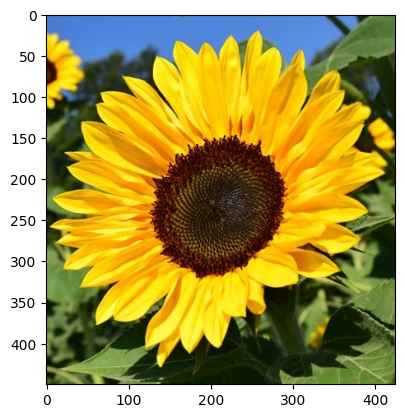

In [12]:
img = cv.imread('flower.jpg')
img = img[:, 250:, ::-1]
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]
plt.imshow(img)
plt.show()
s = np.array([[0.5, 0],[0, 0.5]])
cv_resize = cv.resize(img, (0, 0), fx = 2, fy=2)
R_ = transform(R, s)
G_ = transform(G, s)
B_ = transform(B, s)
row, col = R_.shape
new_img = np.zeros((row, col, 3))

new_img[:, :, 0] = R_
new_img[:, :, 1] = G_
new_img[:, :, 2] = B_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


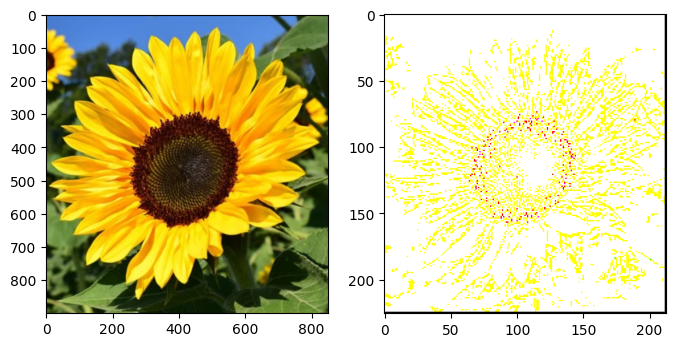

In [13]:
fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(cv_resize)
plt.subplot(122)
plt.imshow(new_img)
plt.show()

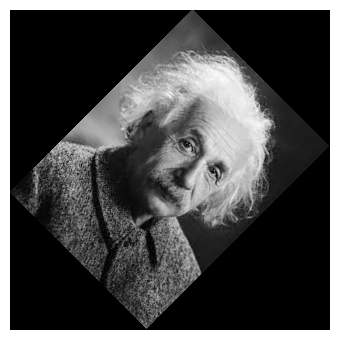

In [14]:
img = cv.imread('einstein.jpg', cv.IMREAD_GRAYSCALE)
d = -45
r = np.deg2rad(d)
s = np.array([[np.cos(r), -np.sin(r)],[np.sin(r), np.cos(r)]])
# s = np.array([[2, 0], [0, 5]])
img2 = transform(img, s)

displayImageActualSize(img2)

In [13]:
img.shape, img2.shape

((259, 194), (320, 320))

In [14]:
row, col = img.shape[0], img.shape[1]
x = np.repeat(np.arange(col).reshape(1, col), row, axis=0)

In [15]:
x

array([[  0,   1,   2, ..., 191, 192, 193],
       [  0,   1,   2, ..., 191, 192, 193],
       [  0,   1,   2, ..., 191, 192, 193],
       ...,
       [  0,   1,   2, ..., 191, 192, 193],
       [  0,   1,   2, ..., 191, 192, 193],
       [  0,   1,   2, ..., 191, 192, 193]])

In [16]:
x.shape

(259, 194)

In [17]:
row, col = img.shape[0], img.shape[1]
a = np.array([[np.array([a, b]).reshape(2, 1) for b in range(col)] for a in range(row)])

In [18]:
a.shape

(259, 194, 2, 1)

In [19]:
a[258, 193]

array([[258],
       [193]])

# apply shear transformation to an image 

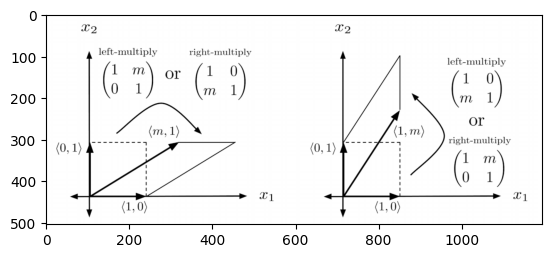

In [20]:
img = cv.imread('shear.png', cv.IMREAD_COLOR)
plt.imshow(img[:, :, ::-1])
plt.show()

# Affine transformation matrix
add "1" for every point cordination and [0, 0, 1] for scale matrix at last row posision

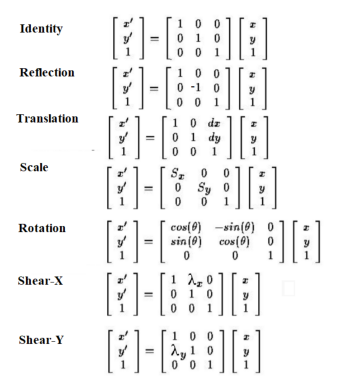

In [21]:
img = cv.imread('affine_transformation.png')
plt.imshow(img[:, :, ::-1])
plt.axis(False)
plt.show()

In [10]:
def boundryAffine(img, s):
    row, col = img.shape[0], img.shape[1]
    cords = np.array([[0, 0, 1],
                      [0, col-1, 1],
                      [row-1, 0, 1],
                      [row-1, col-1, 1]])
    cords_prim = np.dot(s, cords.T)
    minR, minC, _ = np.min(cords_prim, axis=1).astype(np.int64)
    maxR, maxC, _ = (np.ceil(np.max(cords_prim, axis=1))).astype(np.int64)
    H = maxR - minR + 1
    W = maxC - minC + 1
    
    return minR, minC, maxR, maxC, H, W

def transformAffine(img, s):
    minR, minC, maxR, maxC, H, W = boundryAffine(img, s)
    img2 = np.zeros((H, W), dtype=np.uint16)
    s_inv = np.linalg.inv(s)
    for i in range (minR, maxR):
        for j in range(minC, maxC):
            p_prim = np.array([i, j, 1])
            new_i, new_j, _ = np.dot(s_inv, p_prim)
            img2[i - minR, j - minC] = bilinearInterpolation(img, new_i, new_j)
    
    return img2

# Rotate around any point
first we need transform image to new position

for apply different transformation we need define transformation matrix first, then multiply them

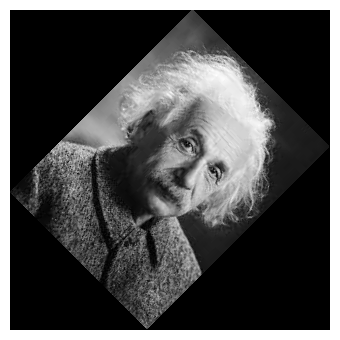

In [11]:
img = cv.imread('einstein.jpg', cv.IMREAD_GRAYSCALE)
d = -45
r = np.deg2rad(d)
r_m = np.array([[np.cos(r), -np.sin(r), 0],
                [np.sin(r), np.cos(r), 0],
                [0, 0, 1]])
t_m = np.array([[1, 0, -100],
                [0, 1, -200],
                [0, 0, 1]])

s = np.linalg.inv(t_m).dot(r_m).dot(t_m)

img2 = transformAffine(img, s)

displayImageActualSize(img2)

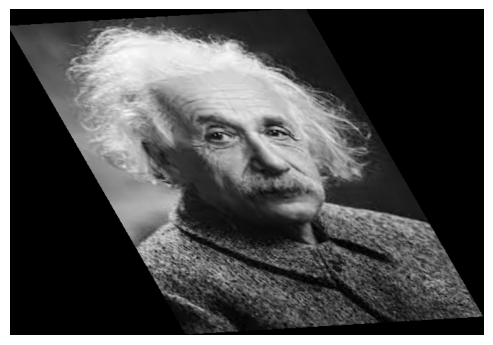

In [12]:
img = cv.imread('einstein.jpg', cv.IMREAD_GRAYSCALE)
d = 30
r = np.deg2rad(d)
r_m = np.array([[np.cos(r), -np.sin(r), 0],
                [np.sin(r), np.cos(r), 0],
                [0, 0, 1]])
t_m = np.array([[1, 0, -100],
                [0, 1, -200],
                [0, 0, 1]])
sh_m = np.array([[1, 0.5, 0],
                 [0, 1, 0],
                 [0, 0, 1]])
s_m = np.array([[2, 0, 0],
                [0, 2, 0],
                [0, 0, 1]])


# transform -> scale -> rotate -> shear
s = np.linalg.inv(t_m).dot(s_m).dot(r_m).dot(sh_m).dot(t_m)

img2 = transformAffine(img, s)

plt.imsave('einstein_Affine.jpg', img2)
displayImageActualSize(img2)

# if our scale matrix doesn't Affine 
output cordinate will have third item which is not "1" so we must divided cordinate by that number

In [38]:
def boundryProjective(img, s):
    row, col = img.shape[0], img.shape[1]
    cords = np.array([[0, 0, 1],
                      [0, col-1, 1],
                      [row-1, 0, 1],
                      [row-1, col-1, 1]])
    cords_prim = np.dot(s, cords.T)
    cords_prim /= cords_prim[2, :]
    minR, minC, _ = np.min(cords_prim, axis=1).astype(np.int64)
    maxR, maxC, _ = (np.ceil(np.max(cords_prim, axis=1))).astype(np.int64)
    H = maxR - minR + 1
    W = maxC - minC + 1
    
    return minR, minC, maxR, maxC, H, W

def transformProjecive(img, s):
    minR, minC, maxR, maxC, H, W = boundryProjective(img, s)
    img2 = np.zeros((H, W), dtype=np.uint16)
    s_inv = np.linalg.inv(s)
    for i in range (minR, maxR):
        for j in range(minC, maxC):
            p_prim = np.array([i, j, 1])
            point = np.dot(s_inv, p_prim)
            new_i, new_j, _ = point / point[2]
            img2[i - minR, j - minC] = bilinearInterpolation(img, new_i, new_j)
    
    return img2

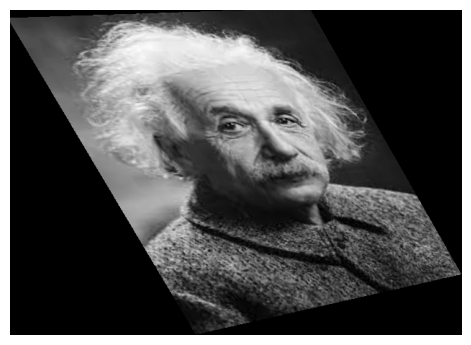

In [46]:
img = cv.imread('einstein.jpg', cv.IMREAD_GRAYSCALE)
d = 30
r = np.deg2rad(d)
r_m = np.array([[np.cos(r), -np.sin(r), 0],[np.sin(r), np.cos(r), 0], [0, 0, 1]])
t_m = np.array([[1, 0, -100], [0, 1, -200], [0, 0, 1]])
sh_m = np.array([[1, 0.5, 0],[0, 1, 0], [0, 0, 1]])
s_m = np.array([[2, 0, 0],[0, 2, 0], [0, 0, 1]])


# transform -> scale -> rotate -> shear
s = np.linalg.inv(t_m).dot(s_m).dot(r_m).dot(sh_m).dot(t_m)
s[2, :] = np.array([0.0001, 0.001, 1])

img2 = transformProjective(img, s)

displayImageActualSize(img2)

In [47]:
plt.imsave('einstein_Projective.jpg', img2)